In [1]:
import os 
import cv2
import numpy as np
from skimage import transform

import matplotlib.pyplot as plt
%matplotlib inline

# local libraries
from utils import line_intersection

In [131]:
rad2deg = 180 / np.pi
figsize = (12, 8)
# indices, `DP' = data point
DP1, DP2 = 0, 1
X, Y = 0, 1
save_figures = False

In [142]:
path = '/scratch/ssd/cciw/sample_data/'
images = os.listdir(path)

file = '1340_2016-07-11_1_GLN_3447.JPG' # 5/5 (3776, 6720, 3)
#file = '1340_2016-07-11_2_GLN_3450.JPG' # 4/5 (4912, 7360, 3)
#file = '1340_2016-07-11_3_GLN_3452.JPG' # 5/5 (4912, 7360, 3)
#file = '1349_2016-07-06_2_GLN_3061.JPG'  # 3/5, step 3 lines are offset, probably because portrait vs. landscape mode
#file = '1342_2016-07-07_2_GLN_3182.JPG'
#file = 'GLNI_456-1_2016-07-20_image-2.jpg' # (4924, 7378, 3)
outpath = file.split('.')[0]

In [143]:
f = os.path.join(path, file)
im = cv2.imread(f)
im.shape  # (height, width)

(3776, 6720, 3)

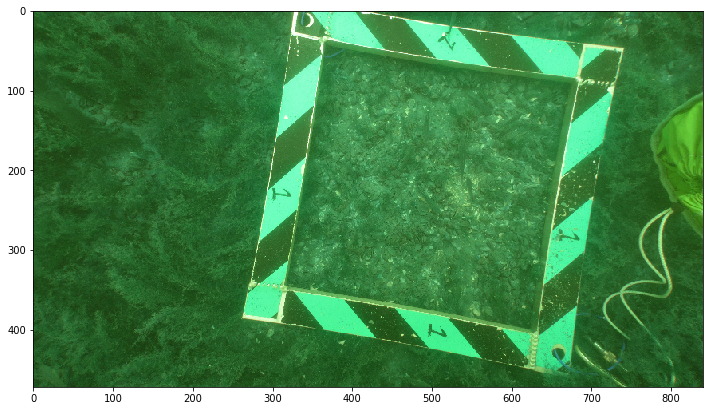

In [144]:
ds = 8  # naive downsampling by factor of 8
plt.figure(figsize=figsize)
plt.imshow(im[::ds, ::ds])

0 172.00
0 (-824, -170) (839, 63)


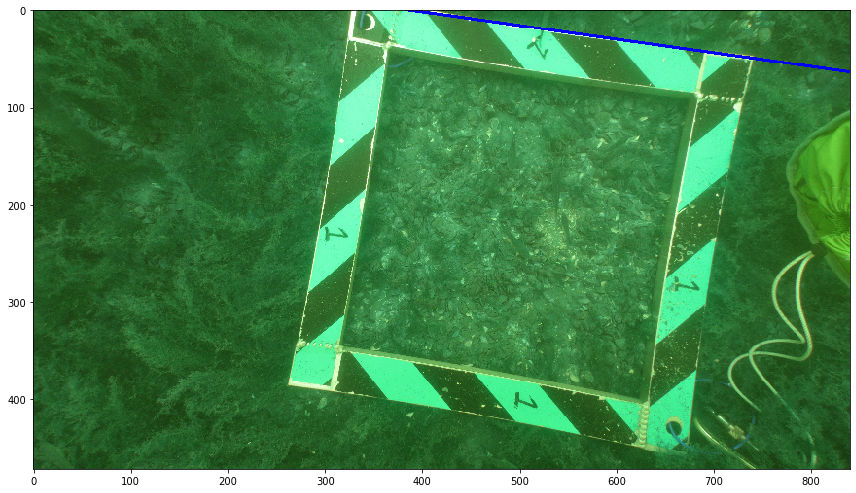

In [145]:
'''
@param threshold Accumulator threshold parameter. Only those lines are returned that get enough
       votes ( \f$>\texttt{threshold}\f$ ).
@param minLineLength Minimum line length. Line segments shorter than that are rejected.
@param maxLineGap Maximum allowed gap between points on the same line to link them.
'''
img = np.ascontiguousarray(im[::ds, ::ds], dtype=np.uint8)
img_h = img.shape[0]
img_w = img.shape[1]
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

edges = cv2.Canny(gray, 20, 400, L2gradient=True) # GLN_3447

# @param rho Distance resolution of the accumulator in pixels.
rho = 1  
# @param theta Angle resolution of the accumulator in radians.
theta = np.pi / 90  # note, with 180 getting too many overlapping lines.

lines  =  cv2.HoughLines(edges, rho, theta, threshold=100)
N = 1
coords = np.zeros((N, 2, 2)).astype('int') # points, start/end, x/y
angles = np.zeros(N)
for i in range(len(lines[:N])):
    for r, theta in lines[i]:
        # theta is normal to the line wrt x-axis, so we subtract 90
        if r > 0:
            angles[i] = 90 - theta * 180 / np.pi
        else: 
            angles[i] = 270 - theta * 180 / np.pi
        print(i, '%.2f' % angles[i])
        a = np.cos(theta)
        b = np.sin(theta)
        x0, y0 = a * r, b * r
        x1 = int(x0 + img_w * -b)
        y1 = int(y0 + img_w *  a)
        x2 = int(x0 - img_w * -b)
        y2 = int(y0 - img_w *  a)
        #coords.append([[x1, y1], [x2, y2]])
        coords[i, DP1, X] = x1
        coords[i, DP1, Y] = y1
        coords[i, DP2, X] = x2
        coords[i, DP2, Y] = y2
        print(i, (x1, y1), (x2, y2))
        cv2.line(img, (x1, y1), (x2, y2), (0, 0, 255), 2)  # 2 is the line width
plt.figure(figsize=figsize)
plt.imshow(img)
#plt.xlabel('x')
#plt.ylabel('y')
plt.tight_layout()
if save_figures:
    plt.savefig('img/' + outpath + '-Step-1.png')
plt.show()

In [158]:
lines[0]

array([[-54.       ,   1.7104226]], dtype=float32)

## Probabilistic HoughLines

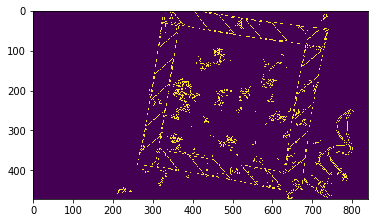

In [156]:
plt.imshow(edges)

Found 15 lines


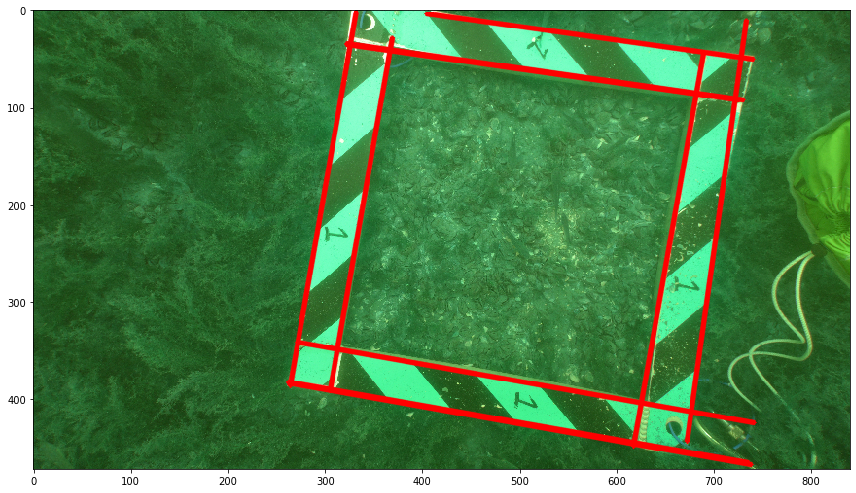

In [190]:
img = np.ascontiguousarray(im[::ds, ::ds], dtype=np.uint8)
img_h = img.shape[0]
img_w = img.shape[1]
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

# @param canny_threshold1 Histeresis threshold 1
# @param canny_threshold2
canny_thresh1 = 40
canny_thresh2 = 400

# run the Canny edge detector on the rotated gray scale image
edges = cv2.Canny(gray, threshold1=canny_thresh1, threshold2=canny_thresh2, L2gradient=False) # GLN_3447

# @param rho Distance resolution of the accumulator (pixels).
rho = 1  

# @param theta Angle resolution of the accumulator (radians).
theta = np.pi / 90

# @param threshold Accumulator threshold, return lines with more than threshold of votes. (intersection points)
threshold = 100

# @param minLineLength Minimum line length. Line segments shorter than that are rejected. (pixels)
mLL = 300

# @param maxLineGap Maximum allowed gap between points on the same line to link them. (pixels)
mLG = 100
#mLG = 200 # increased to 200 for GLNI_456-1_2016-07-20_image-2.jpg

# run the probabilistic hough lines transform
linesP = cv2.HoughLinesP(edges, rho, theta, threshold=threshold, minLineLength=mLL, maxLineGap=mLG)

# @param lines The extremes of the detected lines if any (<N_LINES_FOUND>, 1, x_0, y_0, x_1, y_1). (pixels)
print('Found %d lines' % len(linesP))

N = 10  # top N results to draw
if linesP is not None:
    for i in range(len(linesP[:N])):
        l = linesP[i][0]
        pt1 = (l[0], l[1])
        pt2 = (l[2], l[3])
        rgb = (255, 0, 0)
        line_width = 3
        cv2.line(img, pt1, pt2, rgb, line_width, cv2.LINE_AA)
plt.figure(figsize=figsize)
plt.imshow(img)
#plt.xlabel('x')
#plt.ylabel('y')
plt.tight_layout()
if save_figures:
    plt.savefig('img/' + outpath + '-Step-2.png')
plt.show()

In [170]:
# line below origin, rho positive, angle less than 180
# line above origin, rho negative, angle less than 180
#lines = cv2.HoughLines(edges, rho, theta, threshold=100)

if lines[0, 0, 1] > 0:
    if lines[0, 0, 0] > 0 or lines[0, 0, 1] < np.pi / 2:
        print('rho positive, or theta < 90')
        rot_deg = 90 - lines[0, 0, 1] * rad2deg
    else:
        print('rho negative')
        rot_deg = 90 - lines[0, 0, 1] * rad2deg
        #rot_deg = 180 - lines[0, 0, 1] * rad2deg
else:
    rot_deg = 0
t = rot_deg / rad2deg
print(t)

rho negative
-0.1396263082835336


In [171]:
#lines[0, 0, 1] * rad2deg

97.999998173639

In [173]:
#np.pi / 2

In [174]:
coordsP = np.zeros((np.minimum(N, len(linesP)), 2, 2)).astype('int') # points, start/end, x/y

for i in range(len(linesP[:N])):
    l = linesP[i][0]
    coordsP[i, DP1, X] = l[0] # x1
    coordsP[i, DP1, Y] = l[1] # y1
    coordsP[i, DP2, X] = l[2] # x2
    coordsP[i, DP2, Y] = l[3] # y2
    
R = np.array([[np.cos(-t), -np.sin(-t)],
              [np.sin(-t),  np.cos(-t)]])
coords = np.dot(coordsP, R)

correction_factor = coordsP[0, DP1, Y] - coords[0, DP1, Y]

for i in range(len(linesP[:N])):
    coords[i, DP1, Y] += correction_factor
    coords[i, DP2, Y] += correction_factor

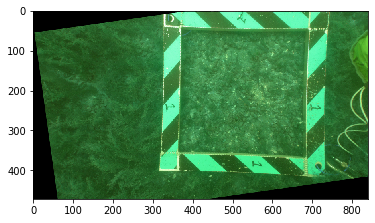

In [175]:
#plt.figure(figsize=(12, 10))
center = (coordsP[0, DP1, X], coordsP[0, DP1, Y])
imgr = transform.rotate(
    np.ascontiguousarray(
        im[::ds, ::ds], dtype=np.uint8
    ), -rot_deg, center=center, resize=False)
imgr = (255 * imgr).astype(np.uint8)
clean_img = imgr.copy()
plt.imshow(imgr[:, :])
plt.show()

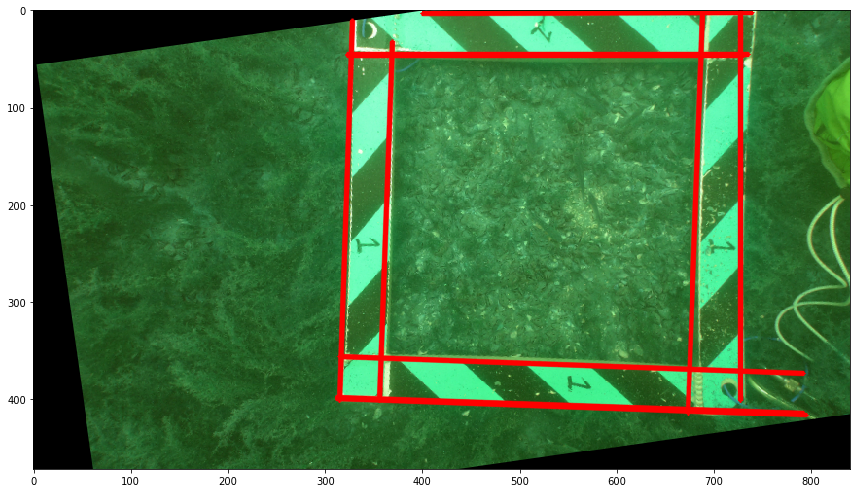

In [176]:
for i in range(len(linesP[:N])):
    cv2.line(imgr, (int(coords[i, DP1, X]),
                    int(coords[i, DP1, Y])),
                   (int(coords[i, DP2, X]),
                    int(coords[i, DP2, Y])),
             (255, 0, 0), 3, cv2.LINE_AA)
plt.figure(figsize=figsize)
plt.imshow(imgr)
plt.tight_layout()
if save_figures:
    plt.savefig('img/' + outpath + '-Step-3.png')

# Find Intersection Points

In [65]:
#print(line_intersection((coords[0, DP1], coords[0, DP2]), (coords[1, DP1], coords[0, DP2])))

In [177]:
corners = []
for i in range(len(coords)):
    for j in range(i + 1, len(coords)):
        intersection = line_intersection((coords[i, DP1], coords[i, DP2]), 
                                         (coords[j, DP1], coords[j, DP2]))
        # check if intersection is a valid corner
        if intersection is not None:
            cond1 = 0 < intersection[X] and intersection[X] < img_w
            cond2 = 0 < intersection[Y] and intersection[Y] < img_h
            if cond1 and cond2:
                corners.append(intersection)
corners_np = np.asarray(corners)
len(corners_np)

24

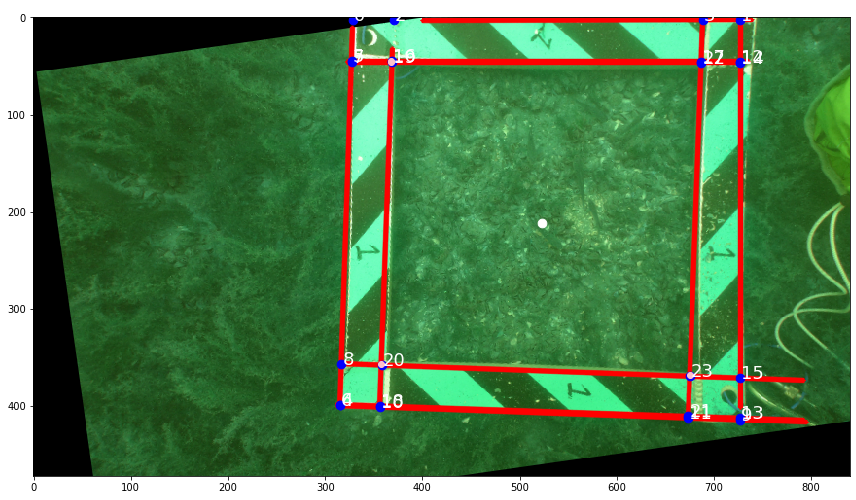

In [178]:
s = 75
fig = plt.figure(figsize=figsize)
ax2 = fig.gca()

centroid = corners_np.mean(axis=0, keepdims=True)[0]
corner_dist = np.linalg.norm(corners_np - centroid, axis=1)
indices = np.argsort(corner_dist)
crop = corners_np[indices][:4].astype('int')

for i in range(len(corners_np)):
    ax2.scatter(corners_np[i, 0], corners_np[i, 1], c='b', s=s)
    ax2.annotate(i, xy=(corners_np[i, 0] + 1, corners_np[i, 1] + 1), 
                 c='white', fontsize=18)
ax2.scatter(centroid[0], centroid[1], c='white', s=s)
ax2.scatter(crop[:, 0], crop[:, 1], c='pink')
ax2.imshow(imgr)
plt.tight_layout()

In [179]:
# check crop points are equidistant
crop_dist_centroid = np.linalg.norm(crop - centroid, axis=1)
print(crop_dist_centroid.var())
print(crop_dist_centroid)

16.69972554308264
[217.96546071 220.87293683 226.94730896 227.67783717]


In [180]:
crop_distances = []
for i in range(len(crop)):
    for j in range(i + 1, len(crop)):
        crop_distances.append((i, j, int(np.linalg.norm(crop[i] - crop[j]))))
crop_distances = np.asarray(crop_distances)

In [192]:
cond1 = crop_dist_centroid.var() > 10
cond2 = (crop_distances[:, 2] < 200).sum() > 1

if cond1 and cond2:
    # Reject outliers
    corner_distances = []
    for i in range(len(corners_np)):
        for j in range(i + 1, len(corners_np)):
            corner_distances.append(
                (i, j, int(np.linalg.norm(corners_np[i] - corners_np[j])))
            )
    print(len(corner_distances))
    
    corner_distances_np = np.asarray(corner_distances)
    distances = corner_distances_np[:, 2]
    #disc_data = np.digitize(np.asarray(corner_distances)[:, 2], 
    #                        bins=np.linspace(min(distances), max(distances), 75))
    
    values, counts = np.unique(distances, return_counts=True)
    print(values)
    print(counts)
    
    nb_terms = (counts > 2).sum()
    long_mask = distances == values[np.argsort(counts)[-1]]
    print(long_mask.sum())

    for i in range(2, nb_terms):
        long_mask |= distances == values[np.argsort(counts)[-i]]
        print(i, long_mask.sum())

    # any points contributing to long line segments are considered inliers
    inliers = np.unique(corner_distances_np[long_mask][:, :2])
    print(inliers)
    
    small_mask = corner_distances_np[:, 2] < values[np.argsort(counts)[-3]]
    small_dist = corner_distances_np[small_mask]
    
    sm_values, sm_counts = np.unique(small_dist[:, :2], return_counts=True)
    #print(values)  # corners implicated 
    #print(counts)
    outliers = sm_values[sm_counts > 1]
    print(outliers)

    # filter points that are part of lines that are too small
    for out in outliers:
        corners_np[out] = -1
    # filer points that aren't contributing to a long segment
    for i in range(len(corners_np)):
        if i not in inliers:
            corners_np[i] = -1
    corners_clean_np = corners_np[corners_np > -1]
    corners_clean_np = corners_clean_np.reshape(-1, 2)
    
    centroid = corners_clean_np.mean(axis=0, keepdims=True)[0]
    corner_dist = np.linalg.norm(corners_clean_np - centroid, axis=1)
    indices = np.argsort(corner_dist)
    crop = corners_clean_np[indices][:4].astype('int')

    # check crop points are equidistant
    crop_dist_centroid = np.linalg.norm(crop - centroid, axis=1)

In [193]:
"""
Note that 10 is an arbitrary threshold on the variance 
of the distances of the crop points to the centroid.
The consequence of incorrectly choosing this value 
is minor as the crop area will be estimated from the 
best 2 of 4 points. If we already have the correct
4 interior points, we can skip this error check.
"""
if crop_dist_centroid.var() > 10:
    # Reject outliers
    crop_distances = []
    for i in range(len(crop)):
        for j in range(i + 1, len(crop)):
            crop_distances.append((i, j, int(np.linalg.norm(crop[i] - crop[j]))))
    crop_distances = np.asarray(crop_distances)        

    cts = np.zeros(len(crop))
    thresh = np.median(crop_distances[:, 2])
    for i in range(len(crop_distances)):
        if crop_distances[i, 2] > thresh:
            cts[crop_distances[i, 0]] += 1
            cts[crop_distances[i, 1]] += 1
    ref_point = np.argmax(cts)

    # the second reference point is the one with min dist to the ref_point
    best = 1000
    for i in range(len(crop)):
        if i != ref_point:
            dist_to_ref = int(np.linalg.norm(crop[ref_point] - crop[i]))
            #print(i, dist_to_ref)
            if dist_to_ref < best:
                best = dist_to_ref
                best_idx = i
    #print(best_idx)
    print(crop[ref_point])
    print(crop[best_idx])
    
    start_x = np.minimum(crop[best_idx, 0], crop[ref_point, 0])
    end_x   = np.maximum(crop[best_idx, 0], crop[ref_point, 0])
    delta_x = end_x - start_x

    start_y = np.minimum(crop[best_idx, 1], crop[ref_point, 1])
    end_y   = np.maximum(crop[best_idx, 1], crop[ref_point, 1])
    delta_y = end_y - start_y

    if delta_x > delta_y:
        end_y  = int(np.maximum(end_y, delta_x)) + start_y
    else:
        end_x  = int(np.maximum(end_x, delta_y)) + start_x

# else use the existing points
else:
    print("Using existing crop pts")
    #crop.sort(0)
    buffer = 10
    start_x = crop[:, 0].min() + buffer # crop[ 0, 0]
    end_x   = crop[:, 0].max() - buffer # crop[-2, 0]
    start_y = crop[:, 1].min() + buffer # crop[ 1, 1]
    end_y   = crop[:, 1].max() - buffer # crop[ 2, 1]

[675 368]
[357 357]


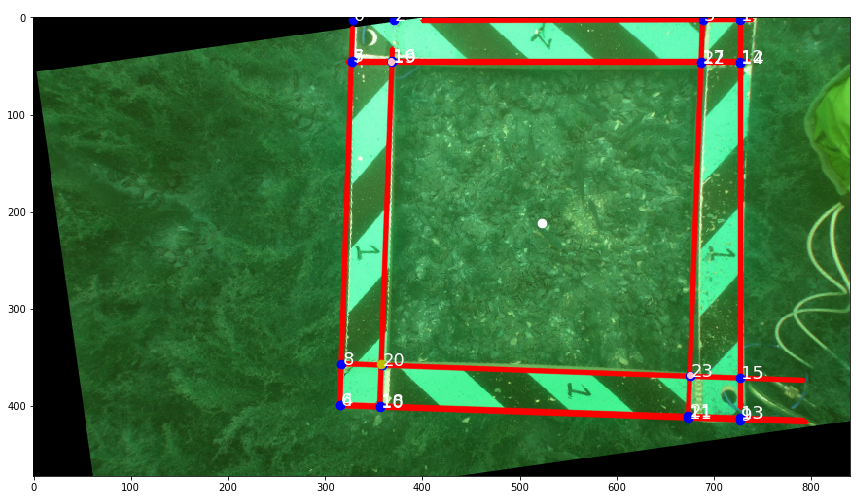

In [194]:
s = 75
fig = plt.figure(figsize=figsize)
ax2 = fig.gca()
for i in range(len(corners_np)):
    #if i not in outliers:
    ax2.scatter(corners_np[i, 0], corners_np[i, 1], c='b', s=s)
    ax2.annotate(i, xy=(corners_np[i, 0] + 1, corners_np[i, 1] + 1), 
                 c='white', fontsize=18)
ax2.scatter(centroid[0], centroid[1], c='white', s=s)
ax2.scatter(crop[:, 0], crop[:, 1], c='pink')
ax2.scatter(start_x, start_y, c='y', s=s)
ax2.scatter(end_x,   end_y, c='y', s=s)
ax2.imshow(imgr)
plt.tight_layout()
if save_figures:
    plt.savefig('img/' + outpath + '-Step-4-clean-corners.png')

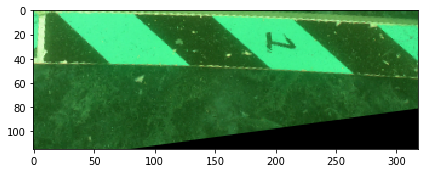

In [195]:
buffer = 10
plt.figure(figsize=(6, 6))
cropped_img = clean_img[start_y:end_y, start_x:end_x, :]
plt.imshow(cropped_img)
plt.tight_layout()
if save_figures:
    plt.savefig('img/' + outpath + '-Step-5.png')